In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt
%matplotlib inline

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import pynapple as nap

In [2]:
sess_name="e15_13f1_220117"#'e13_26m1_210913'#
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"#'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913' #
py_data_dir = os.path.join(data_dir_full,"py_data")
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr_df=  fr_['df']
fr_pyr = fr_['df']['pyr']
fr_int = fr_['df']['int']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)
cell_cols_int =np.array(cell_cols['int'],dtype=object)


In [3]:
data_dir_full = data_dir_full
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [4]:
import glob
mono_res=glob.glob(os.path.join(data_dir_full,'*mono_res*'))[0]
mono_res = dpn.loadmat_full(mono_res,'mono_res')

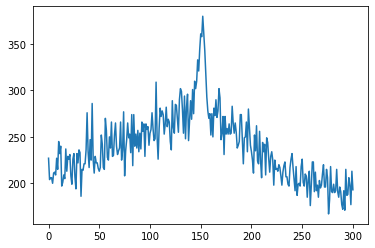

In [116]:
%matplotlib inline
plt.plot(mono_res.ccgR[:,0,101]) #98

# plt.xlim([140,160])

In [77]:
mono_res.binSize

array(0.0004)

In [5]:
# filter_windowsize = mono_res.conv_w
# sigma = 0.01 / mono_res.binSize
# gaus_filt = scipy.signal.gaussian(filter_windowsize,sigma)
# hollow_frac = 0.6
# gaus_filt[len(gaus_filt)//2] = gaus_filt[len(gaus_filt)//2] * hollow_frac
# gaus_filt = gaus_filt/gaus_filt.sum()


In [6]:
# x = mono_res.ccgR[:,0,59]
# x_augmented = np.concatenate([np.flip(x),x,np.flip(x)])
# x_filt = scipy.signal.convolve(x_augmented,gaus_filt, mode='same')[len(x):(len(x)*2)]

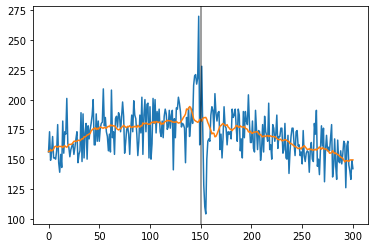

In [9]:
plt.plot(x)
plt.plot(x_filt)
plt.axvline(150,color='k',alpha=0.5)

In [5]:
from scipy.stats import poisson
def get_p_n_or_more_given_lambda(n,lam):
    return 1-poisson.cdf(n-1,lam)- 0.5 * poisson.pmf(n,lam)

def get_p_n_or_fewer_given_lambda(n,lam):
    return poisson.cdf(n,lam)

def get_pval_for_peak_in_range(ccg,ccg_filtered,peak_range_int,valence=1):
    '''
    do testing for one range, compare the peak (positive or negative) against the slow baseline lambda
    '''

    window_size = len(ccg)
    assert window_size%2==1
    mid_index = int(window_size // 2)
    peak_check_range = slice(mid_index + peak_range_int[0],mid_index + peak_range_int[1])
    if valence > 0 :
        peak_ind_within = np.argmax(ccg[peak_check_range])
    if valence < 0 :
        peak_ind_within = np.argmin(ccg[peak_check_range])
    
    peak_val = ccg[peak_check_range][peak_ind_within]
    peak_slow_lam = ccg_filtered[peak_check_range][peak_ind_within]
    if valence > 0:
        pval = get_p_n_or_more_given_lambda(peak_val, peak_slow_lam)
    elif valence < 0:
        pval = get_p_n_or_fewer_given_lambda(peak_val, peak_slow_lam)

    return pval, peak_val, peak_slow_lam
    

def get_peak_and_test(ccg,ccg_filtered,valence=1,bin_size=0.0004,peak_range=(0.0008,0.0028),peak_range_int=(2,7),
                      anti_causal_peak_range=(-0.002,0),anti_causal_peak_range_int=(-5,0),pfast_thresh=0.001, pcausal_thresh=0.0026
                     ):
    '''
    ccg: window_size, has to be odd
    ccg_filtered: same size as ccg; filtered from a partially hollowed gaussian
    
    do both fast and causal testing
    '''
    
    if peak_range_int is None:
        peak_range_int = (int(peak_range[0]//bin_size),int(peak_range[1]//bin_size))
    if anti_causal_peak_range_int is None:
        anti_causal_peak_range_int = (int(anti_causal_peak_range[0]//bin_size),int(anti_causal_peak_range[1]//bin_size))
    
    
    pval, peak_val, peak_slow_lam = get_pval_for_peak_in_range(ccg,ccg_filtered,peak_range_int,valence=valence)
    _, peak_val_anti_causal, peak_slow_lam_anti_causal = get_pval_for_peak_in_range(ccg,ccg_filtered,anti_causal_peak_range_int,valence=valence)
    
    if valence > 0:
        pval_causal = get_p_n_or_more_given_lambda(peak_val, peak_val_anti_causal)
    elif valence < 0:
        pval_causal = get_p_n_or_fewer_given_lambda(peak_val, peak_val_anti_causal)
        
    con = (pval < pfast_thresh) & (pval_causal < pcausal_thresh)
    
    return con, pval, pval_causal
        
        
    
    
    


In [137]:
# get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=-1)

(False, 0.009240143374553252, 0.0004543954566429124)

In [186]:
# _, peak_val_anti_causal, peak_slow_lam_anti_causal = get_pval_for_peak_in_range(ccg[:,i,j],ccg_filtered[:,i,j],(-8,0),valence=-1)



In [6]:
def get_partially_hollowed_filter(filter_windowsize=25,sigma = 0.01,bin_size=0.0004,hollow_frac = 0.6):
    '''
    sigma, bin_size in s
    filter_windowsize in bin
    '''
    sigma_bin = sigma / bin_size
    gaus_filt = scipy.signal.gaussian(filter_windowsize,sigma_bin)
    gaus_filt[len(gaus_filt)//2] = gaus_filt[len(gaus_filt)//2] * hollow_frac
    gaus_filt = gaus_filt/gaus_filt.sum()
    return gaus_filt
    
    
def filter_ccg(ccg,filter_kwargs={}):
    '''
    ccg: ccg_windowsize x n_neurons x n_neurons
    '''
    gaus_filt = get_partially_hollowed_filter(**filter_kwargs)
    ccg_windowsize=ccg.shape[0]
    ccg_augmented = np.concatenate([np.flip(ccg,axis=0),ccg,np.flip(ccg,axis=0)],axis=0)
    ccg_filtered = scipy.ndimage.convolve1d(ccg_augmented, gaus_filt, mode='reflect',axis=0)[ccg_windowsize:ccg_windowsize*2]
    return ccg_filtered
    

In [7]:
ccg = mono_res.ccgR
ccg_filtered = filter_ccg(ccg,filter_kwargs={})
n_neurons = ccg_filtered.shape[1]

In [8]:
from tqdm import tqdm

In [154]:
%%time 
ccg = mono_res.ccgR
n_neurons = ccg_filtered.shape[1]

# n_neurons=20
exc_res_l = np.zeros((n_neurons,n_neurons))
inh_res_l = np.zeros((n_neurons,n_neurons))
for i in tqdm(range(n_neurons),position=0,leave=True):
    for j in range(n_neurons):
        if i!=j:
            exc_res_l[i,j] = get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=1)[0]
            inh_res_l[i,j] = get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=-1,anti_causal_peak_range_int=(-10,0))[0]
            

100%|██████████| 376/376 [02:59<00:00,  2.09it/s]

CPU times: user 3min, sys: 9.93 s, total: 3min 10s
Wall time: 2min 59s


In [10]:
# seperate: int inhibitory onto pyr
inh_res_l = np.zeros((n_neurons,n_neurons))
int_inds = np.nonzero(~cell_type_mask)[0]
pyr_inds = np.nonzero(cell_type_mask)[0]
for i in tqdm(int_inds,position=0,leave=True):
    for j in pyr_inds:
        inh_res_l[i,j] = get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=-1,anti_causal_peak_range_int=(-10,0))[0]

100%|██████████| 43/43 [00:06<00:00,  6.83it/s]


In [9]:
# # seperate: pyr exc onto int
exc_res_l = np.zeros((n_neurons,n_neurons))
int_inds = np.nonzero(~cell_type_mask)[0]
pyr_inds = np.nonzero(cell_type_mask)[0]
for i in tqdm(pyr_inds,position=0,leave=True):
    for j in int_inds:
        exc_res_l[i,j] = get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=1)[0]

100%|██████████| 333/333 [00:11<00:00, 28.30it/s]


In [17]:
synapses=dict(int_exc_pyr = exc_res_l[~cell_type_mask][:,cell_type_mask],
int_inh_pyr = inh_res_l[~cell_type_mask][:,cell_type_mask],
pyr_exc_int = exc_res_l[cell_type_mask][:,~cell_type_mask],
pyr_inh_int = inh_res_l[cell_type_mask][:,~cell_type_mask])

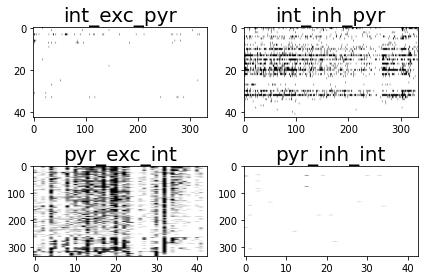

In [164]:
fig,axs=plt.subplots(2,2)
for ii,(k, val) in enumerate(synapses.items()):
    axs.ravel()[ii].imshow(val,aspect='auto')
    axs.ravel()[ii].set_title(k)
plt.tight_layout()

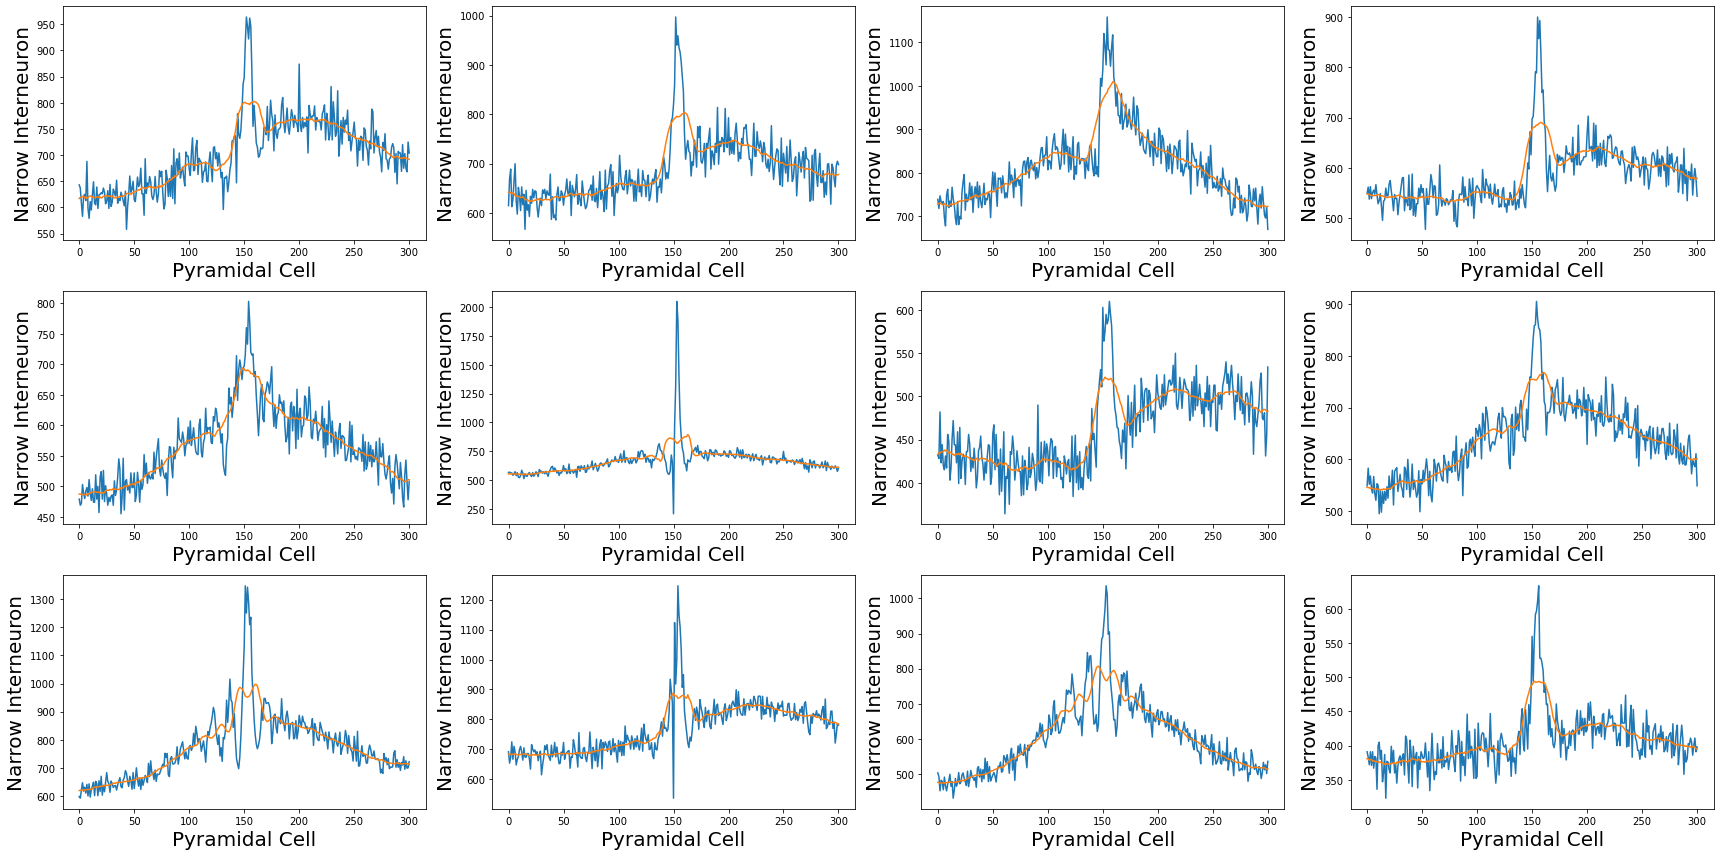

In [246]:
# example excitatory synapses
kk=25
nplots = 12
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for kk in range(nplots):
    i,j=np.nonzero(exc_res_l)[0][kk],np.nonzero(exc_res_l)[1][kk]
    axs.ravel()[kk].plot(ccg[:,i,j])
    axs.ravel()[kk].plot(ccg_filtered[:,i,j])
    axs.ravel()[kk].set_xlabel(cell_metrics['putativeCellType'][i])
    axs.ravel()[kk].set_ylabel(cell_metrics['putativeCellType'][j])
plt.tight_layout()

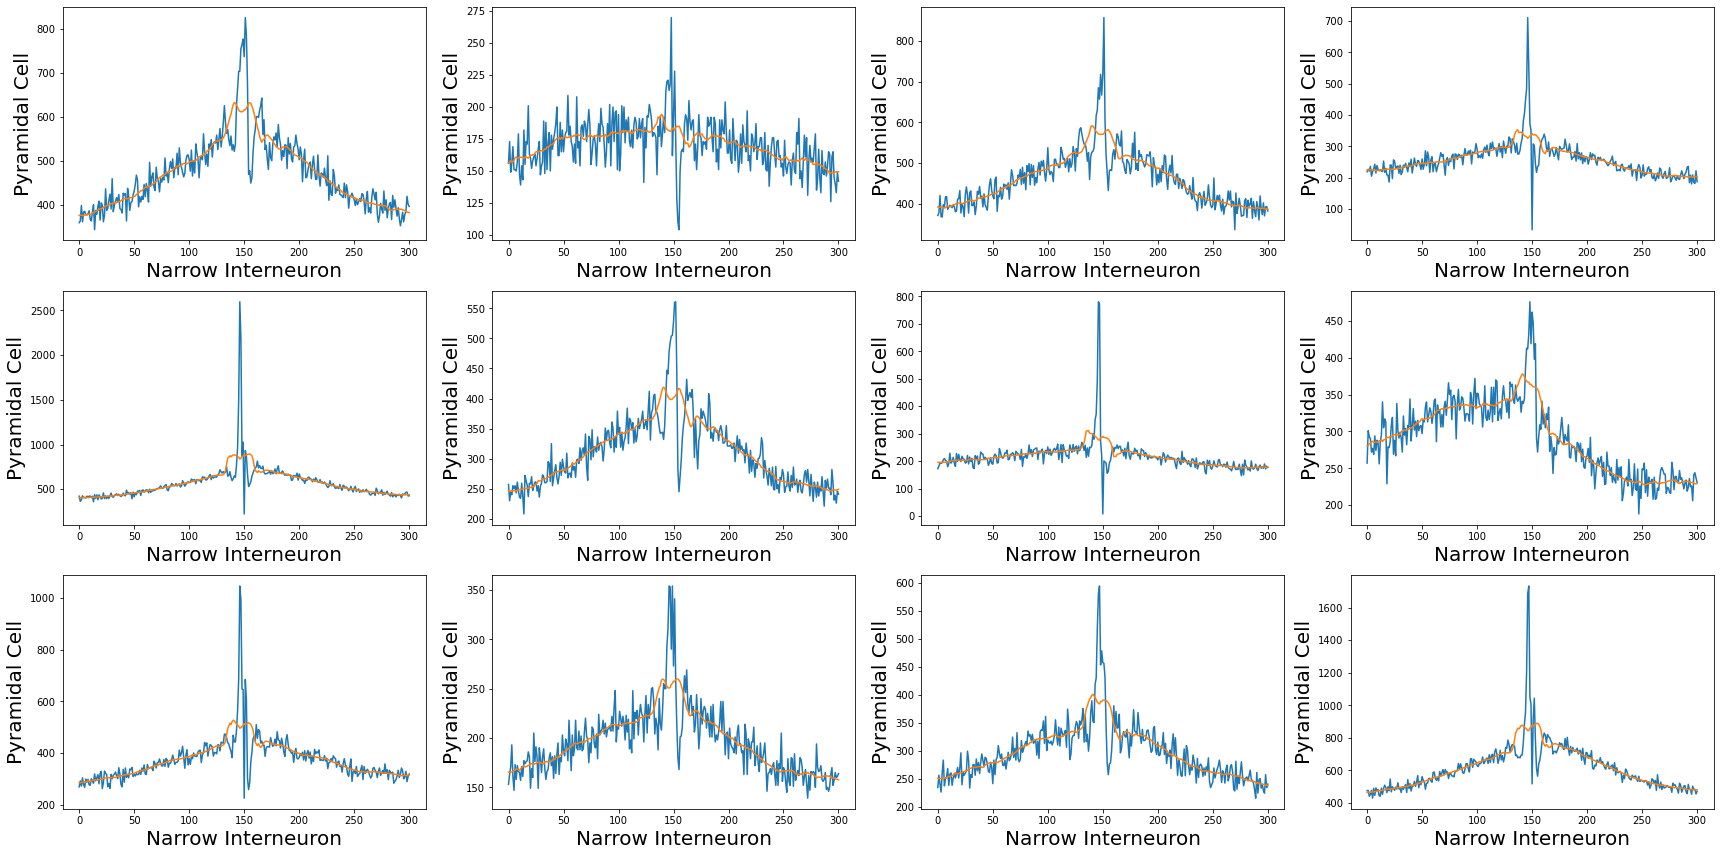

In [231]:
# example inhibitory synapses
kk=25
nplots = 12
fig,axs = ph.subplots_wrapper(nplots,return_axs=True)
for kk in range(nplots):
    i,j=np.nonzero(inh_res_l)[0][kk],np.nonzero(inh_res_l)[1][kk]
    axs.ravel()[kk].plot(ccg[:,i,j])
    axs.ravel()[kk].plot(ccg_filtered[:,i,j])
    axs.ravel()[kk].set_xlabel(cell_metrics['putativeCellType'][i])
    axs.ravel()[kk].set_ylabel(cell_metrics['putativeCellType'][j])
plt.tight_layout()

In [188]:
# get_peak_and_test(x,x_filt,valence=1,bin_size=0.0004,peak_range=(0.0008,0.0028),peak_range_int=(2,7),
#                       anti_causal_peak_range=(-0.002,0),anti_causal_peak_range_int=(-5,0)
#                      )

get_peak_and_test(ccg[:,i,j],ccg_filtered[:,i,j],valence=-1,bin_size=0.0004,peak_range=(0.0008,0.0028),peak_range_int=(2,7),
                      anti_causal_peak_range=(-0.002,0),anti_causal_peak_range_int=(-8,0)
                     )

(False, 6.371614890099358e-05, 0.1524243739481582)

In [247]:
fr_filtered_d={}
fr_to_be_nmfed_d={}
for ct,fr in fr_df.items():
    fr_filtered_d[ct] = copy.copy(fr.query("(speed>=1.)"))
    # fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
    fr_mean_trial_type = fr_filtered_d[ct].groupby(['visitedArm','trial']).mean()[cell_cols[ct]]
    fr_mean_all = fr_filtered_d[ct].groupby('trial').mean()[cell_cols[ct]]

    fr_to_be_nmfed_d[ct] = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}

In [248]:
reload(na)
n_compo = 4
W_d_d,W_sorted_d_d,W_inds_d_d, factor_assignment_d_d, H_sorted_d_d, X_sorted_d_d, X_recon_sorted_d_d, mask_joint_d_d, non_na_original_ind_joint_d_d={},{},{},{},{},{},{},{},{}
for ct, fr_to_be_nmfed in fr_to_be_nmfed_d.items():
    W_d_d[ct],W_sorted_d_d[ct],W_inds_d_d[ct], factor_assignment_d_d[ct], H_sorted_d_d[ct], X_sorted_d_d[ct], X_recon_sorted_d_d[ct], mask_joint_d_d[ct], non_na_original_ind_joint_d_d[ct] = na.nmf_multiple_fr_df_once(fr_to_be_nmfed,n_compo)
    



/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:38: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant
/mnt/home/szheng/ceph/envs/neural/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/mnt/home/szheng/ceph/envs/neural/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/mnt/home/szheng/ceph/envs/neural/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.2

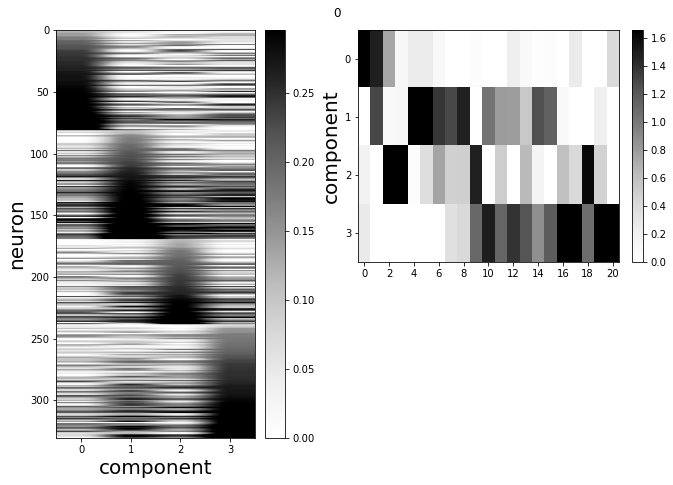

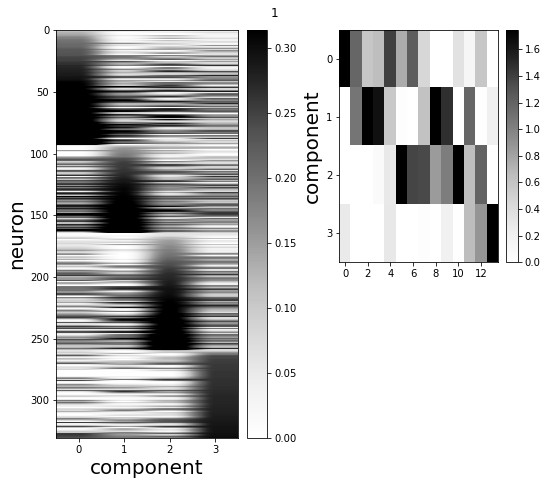

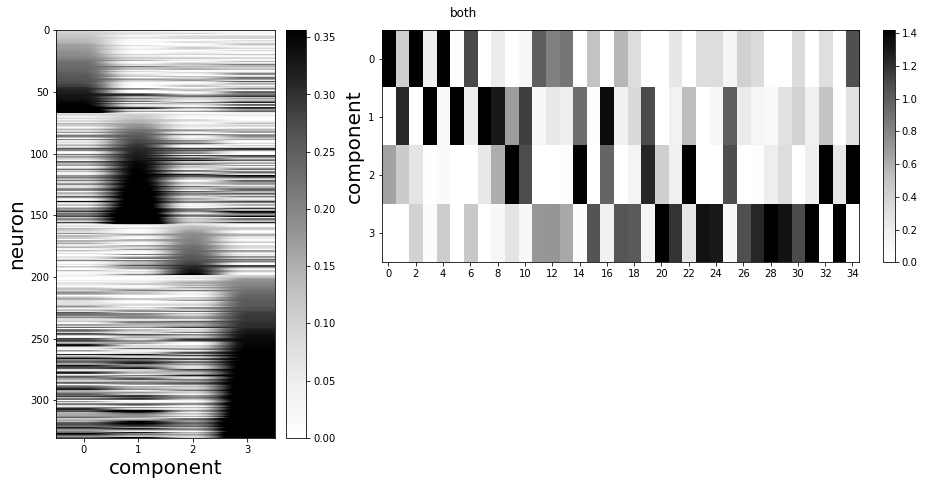

In [249]:
reload(nmfp)
ct='pyr'
for data_key in W_sorted_d_d[ct].keys():
    fig,axd=nmfp.plot_wh(W_sorted_d_d[ct][data_key],H_sorted_d_d[ct][data_key])
    fig.suptitle(data_key)

# relate connectivity to W
## first, regression

In [253]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [263]:
inh_synapse=inh_res_l[~cell_type_mask][:,cell_type_mask][:,non_na_original_ind_joint_d_d['pyr']].T
exc_synapse=exc_res_l[cell_type_mask][:,~cell_type_mask][non_na_original_ind_joint_d_d['pyr']]

(array([ 7., 14., 37., 46., 64., 62., 43., 39., 14.,  5.]),
 array([0.51162791, 0.56046512, 0.60930233, 0.65813953, 0.70697674,
        0.75581395, 0.80465116, 0.85348837, 0.90232558, 0.95116279,
        1.        ]),
 <BarContainer object of 10 artists>)

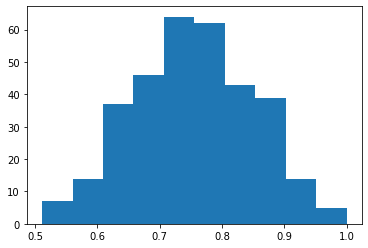

In [271]:
plt.hist((inh_synapse==exc_synapse).sum(axis=1)/exc_synapse.shape[1])

In [260]:
k='0'
W = W_d_d['pyr'][k]
# bin_ms = 10
# corr_as_predictors = inh_res_l[~cell_type_mask][:,cell_type_mask][:,non_na_original_ind_joint_d_d['pyr']].T
corr_as_predictors = exc_res_l[cell_type_mask][:,~cell_type_mask][non_na_original_ind_joint_d_d['pyr']]



In [261]:
reg_res_l = []
corr_as_predictors_const = sm.add_constant(corr_as_predictors)
for k in range(W.shape[1]):
    res=sm.OLS(W[:,k],corr_as_predictors_const).fit()
    reg_res_l.append(res)

In [262]:
for res in reg_res_l:
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.097
Date:                Sun, 04 Sep 2022   Prob (F-statistic):              0.325
Time:                        21:24:46   Log-Likelihood:                 306.31
No. Observations:                 331   AIC:                            -528.6
Df Residuals:                     289   BIC:                            -368.9
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1396      0.020      6.916      0.0

In [256]:
for res in reg_res_l:
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.074
Date:                Sun, 04 Sep 2022   Prob (F-statistic):              0.358
Time:                        21:20:40   Log-Likelihood:                 305.25
No. Observations:                 331   AIC:                            -528.5
Df Residuals:                     290   BIC:                            -372.6
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1577      0.010     15.401      0.0

In [339]:
import scipy.spatial.distance as distance
# synapse_d = distance.pdist(inh_synapse,metric='jaccard')
synapse_d = distance.pdist(exc_synapse,metric='jaccard')
# activity_d = distance.pdist(W,metric='euclidean')
activity_d = distance.pdist(W_d_d['pyr']['both'],metric='euclidean')

In [349]:
# activity_d = distance.pdist(fr_df['pyr'][cell_cols_pyr[non_na_original_ind_joint_d_d['pyr']]].T,metric='euclidean')
activity_d = distance.pdist(fr_df['pyr'].query('visitedArm==0')[cell_cols_pyr[non_na_original_ind_joint_d_d['pyr']]].T,metric='euclidean')
# activity_d = distance.pdist(fr_to_be_nmfed_d['pyr']['both'][cell_cols_pyr[non_na_original_ind_joint_d_d['pyr']]].T,metric='euclidean')



In [377]:
# total spike no normalization
activity_d=distance.pdist(fr_df['pyr'][cell_cols_pyr[non_na_original_ind_joint_d_d['pyr']]].sum(axis=0).values[:,None]) 



In [363]:
df=fr_df['pyr'].query('trial==0')[cell_cols_pyr[non_na_original_ind_joint_d_d['pyr']]].T
df=scipy.stats.zscore(df,axis=1)
activity_d = distance.pdist(df,metric='euclidean')

<AxesSubplot:>

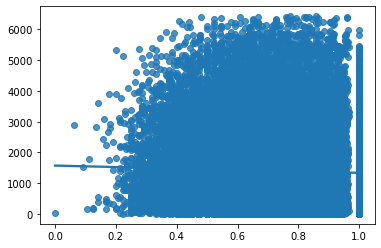

In [378]:
sns.regplot(x=synapse_d,y=activity_d)

In [379]:
scipy.stats.mstats.spearmanr(synapse_d,activity_d)

SpearmanrResult(correlation=-0.04690441462117297, pvalue=5.4900606087318655e-28)

In [380]:
scipy.stats.pearsonr(synapse_d[~np.isnan(activity_d)],activity_d[~np.isnan(activity_d)])

PearsonRResult(statistic=-0.03138922405773109, pvalue=2.1801854995650684e-13)

# zoom in onto individual interneurons

In [29]:
# fn = os.path.join(data_dir_full,'py_data','synapses_all_epoch.p')
# pickle.dump(synapses,open(fn,'wb'))